## Load GSM8K dataset

In [1]:
from datasets import load_dataset
# Load a subset for faster experiments
gsm8k = load_dataset("gsm8k", "main", split="test[:50]")

/home/exouser/miniconda3/envs/reasoning_llm_scratch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load SVAMP datasets

In [3]:
# !git clone https://github.com/arkilpatel/SVAMP.git
import json
from datasets import Dataset

# Load the file from the cloned folder
with open("SVAMP/SVAMP.json", "r") as f:
    raw_data = json.load(f)

# Convert to HuggingFace-style dataset
svamp = Dataset.from_list([
    {"Question": item["Body"], "Answer": str(item["Answer"])}
    for item in raw_data
])

In [4]:
svamp_subset = svamp.select(range(50))

## Define few-shot CoT prompting

In [5]:
# ✍️ Few-shot Chain of Thought prompt examples
few_shot_prefix = """Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.
"""

## Define function used to evaluate model

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
import re

def evaluate_model_fewshot(model_id):
    print(f"Evaluating {model_id} with few-shot CoT...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128)

    correct = 0
    total = 0

    for sample in gsm8k:
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"Q: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]

        match = re.search(r"(\d+(?:\.\d+)?)", output.replace(",", ""))
        if match:
            pred = match.group(1)
            if pred == gt_answer:
                correct += 1
        total += 1

    acc = correct / total
    print(f"Accuracy: {acc:.2%}")
    return acc

## Run across model size and plot the results

Evaluating google/flan-t5-small with few-shot CoT...


Device set to use cuda:0


Accuracy: 2.00%
Evaluating google/flan-t5-base with few-shot CoT...


Device set to use cuda:0


Accuracy: 2.00%
Evaluating google/flan-t5-large with few-shot CoT...


Device set to use cuda:0


Accuracy: 2.00%


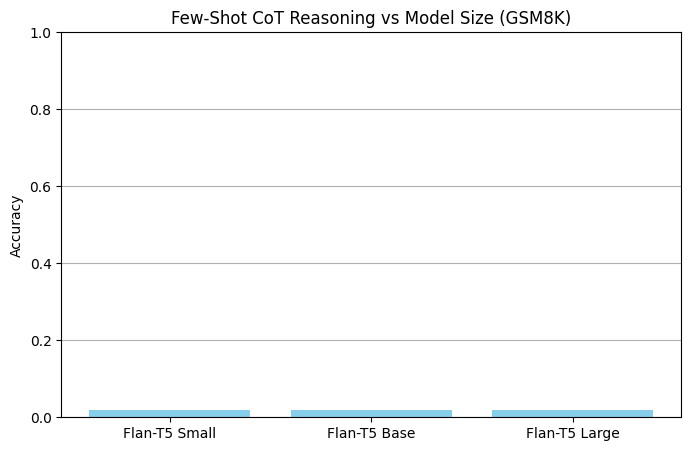

In [8]:
import matplotlib.pyplot as plt

model_ids = {
    "Flan-T5 Small": "google/flan-t5-small",
    "Flan-T5 Base": "google/flan-t5-base",
    "Flan-T5 Large": "google/flan-t5-large"
}

results = []
for label, model in model_ids.items():
    acc = evaluate_model_fewshot(model)
    results.append((label, acc))

# Plotting
labels = [r[0] for r in results]
scores = [r[1] for r in results]
x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, scores, color="skyblue")
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis='y')
plt.show()

## Actual results given by each models

In [9]:
gsm8k_five = gsm8k.select(range(5))  # You can change the range if needed

def print_gsm8k_predictions(model_id, dataset, few_shot_prefix, decoder_only=False):
    from transformers import (
        AutoTokenizer,
        AutoModelForSeq2SeqLM,
        AutoModelForCausalLM,
        pipeline
    )
    import re
    import torch

    # Load appropriate model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if decoder_only:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
        )
        task = "text-generation"
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
        task = "text2text-generation"

    pipe = pipeline(task, model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    for i, sample in enumerate(dataset):
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        if decoder_only:
            output_text = output.split("A:")[-1].strip()
        else:
            output_text = output.strip()

        pred = extract_answer(output_text)

        print(f"\n🔹 Example {i + 1}")
        print(f"Q: {question}")
        print(f"GT Answer: {gt_answer}")
        print(f"Model Output:\n{output_text}")
        print(f"Extracted Answer: {pred}")


print_gsm8k_predictions("google/flan-t5-base", gsm8k_five, few_shot_prefix, decoder_only=False)


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🔹 Example 1
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
GT Answer: 18
Model Output:
First find the total number of eggs Janet lays: 16 eggs / duck = 8 eggs / day. Then find the total number of muffins she bakes: 4 muffins / day * 4 muffins / day = 16 muffins / day. Then find the total number of eggs she sells at the farmers' market: 8 eggs / day + 16 muffins / day = 24 eggs / day. Then find the total number of eggs she sells at the farmers' market: 24 eggs / day + 16 muffins / day = 36 eggs /
Extracted Answer: 36

🔹 Example 2
Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
GT Answer: 3
Model Output:
First find the total number of bolts of blue fiber: 2 bolts / 2 = 2 bolts of white fiber. T

## Observations: 
- Those Flan models are not good at reasoning with very low accuracy on the GSM8K tasks.
- Do reasoning with bigger model

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
import torch

def evaluate_decoder_model(model_id, dataset, few_shot_prefix):
    print(f"\nEvaluating {model_id} on GSM8K...")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    correct = 0
    total = 0

    for sample in dataset:
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        output_text = output.split("A:")[-1].strip()
        pred = extract_answer(output_text)

        if pred and pred.strip().lstrip("0") == gt_answer.strip().lstrip("0"):
            correct += 1
        total += 1

    acc = correct / total
    print(f"Accuracy: {acc:.2%}")
    return acc


In [ ]:
decoder_models = {
    "Zephyr-7B": "HuggingFaceH4/zephyr-7b-alpha",
    "Phi-2": "microsoft/phi-2",
    "TinyLlama-1.1B": "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
}

decoder_results = []
for label, model_id in decoder_models.items():
    acc = evaluate_decoder_model(model_id, gsm8k, few_shot_prefix)
    decoder_results.append((label, acc))

In [13]:
def print_gsm8k_predictions(model_id, dataset, few_shot_prefix):
    from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
    import re
    import torch

    print(f"\n🔍 Predictions from {model_id} on 5 GSM8K Questions")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    for i, sample in enumerate(dataset.select(range(5))):  # first 5 samples
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        output_text = output.split("A:")[-1].strip()
        pred = extract_answer(output_text)

        print(f"\n🟩 Example {i + 1}")
        print(f"Q: {question}")
        print(f"GT Answer: {gt_answer}")
        print(f"Model Output:\n{output_text}")
        print(f"Extracted Answer: {pred}")

# Zephyr
print_gsm8k_predictions("HuggingFaceH4/zephyr-7b-alpha", gsm8k, few_shot_prefix)

# Phi-2
#print_gsm8k_predictions("microsoft/phi-2", gsm8k, few_shot_prefix)

# TinyLlama
#print_gsm8k_predictions("TinyLlama/TinyLlama-1.1B-Chat-v1.0", gsm8k, few_shot_prefix)



🔍 Predictions from HuggingFaceH4/zephyr-7b-alpha on 5 GSM8K Questions
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Loading checkpoint shards: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]
Device set to use cuda:0



🟩 Example 1
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
GT Answer: 18
Model Output:
The train travels 30
Extracted Answer: 30

🟩 Example 2
Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
GT Answer: 3
Model Output:
The recipe calls for
Extracted Answer: None

🟩 Example 3
Q: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
GT Answer: 70000
Model Output:
Josh bought the house for $80,000 and put in $50,000 in repairs. This increased the value of the house by 150%. Let's find out how much the house is worth now.

The original value of the house was $80,000. To fi

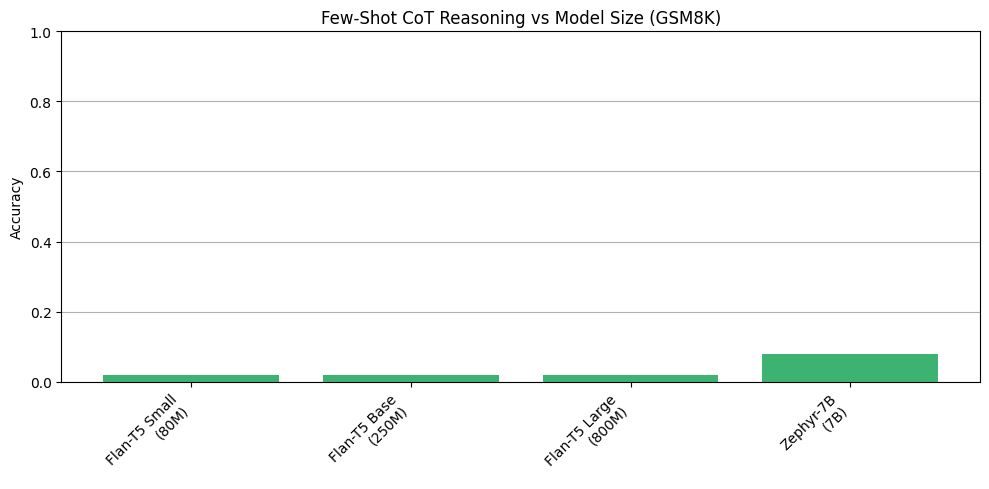

In [14]:
# Combine model labels, sizes, and accuracy
all_results = results + decoder_results

# Define size annotations (approximate)
model_sizes = {
    "Flan-T5 Small": "80M",
    "Flan-T5 Base": "250M",
    "Flan-T5 Large": "800M",
    "Zephyr-7B": "7B",
    "Phi-2": "2.7B",
    "TinyLlama-1.1B": "1.1B"
}

# Update labels with sizes
labels = [f"{name}\n({model_sizes[name]})" for name, _ in all_results]
scores = [score for _, score in all_results]
x = range(len(labels))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x, scores, color="mediumseagreen")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

### What did we learn?

(1) Chain of Thought Reasoning is only effective for bigger models.

(2) The model starts to give reasoning steps if input-output chain of thought examples are provided.

(3) Inspite of using model bigger models upto 7B parameters, accuracy remains low on arithmetic datasets